<h1 style = "text-align: center; ">What Influences a VW Golf Price?</h1>
<h2 style = "text-align: center; ">ST445 - Managing and Visualizing Data</h2>
<h2 style = "text-align: center; ">Candidate IDs: 38682, 50450, 44051</h3>


![Volkswagen Golf](https://m.atcdn.co.uk/vms/media/w980/2fa3b55ab44d4744969f968b5727c8d2.jpg)

##### Overview
##### I. Notebook Preparation
##### II. Introduction and Data Description
    a) Introduction & Research Question
    b) Research Approach
    c) Data Used
##### III. Data Acquisition
    a) ALL: UK Office of National Statistics (ONS)
    b) SAMPLE: UK 100k Used Cars Data
    c) GOLF: Environmental Factors of VW Golf CO2 Emissions
##### IV. Data Visualization
    a) ALL: UK Used Cars & Economic Influence
    b) SAMPLE: UK Used Cars
    c) GOLF: UK Used Cars & Environmental Factors
##### V. Data Modeling
    a) Model Linear Regression on Golf Car Data Variables
##### VI. Conclusion

## I. Notebook preparation

In [499]:
# Import relevant packages
import requests
from bs4 import BeautifulSoup
import pandas as pd
import json
import numpy as np
import os
import zipfile
import sqlite3
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.interpolate import make_interp_spline
import warnings

# Install lxml with conda install anaconda::lxml to use HMTL and XML with Python
# conda install openpyxl

After importing all necessary libararies, we set the standard settings for the notebook regarding the plot sizes of visualising our data.

In [501]:
# Set the global default size of matplotlib figures
plt.rc('figure', figsize=(10, 5))

# Size of matplotlib figures that contain subplots
fizsize_with_subplots = (10, 5)

# Size of matplotlib histogram bins
bin_size = 10

## II. Introduction and Data Description

### II. a) Introduction & Research Question

A friend of ours approached us and wants to sell his old used car, being a VW Golf. He was excited about the Data Science programme at LSE and was convinced that we can leverage our Data Science skills to help him understand the UK used-car market better. (1) In general, he wants  to have more knowledge about what influences the UK used-car market overall. (2) Secondly it would be valuable for him to understand what car features overall are important when selling his car. (3) Seeing as though our friend has a VW Golf, it would be useful for us to shed light on which factors effect this specific segment of the market as well. Finally, he would like to have a rough estimate of a sales price.

To address his request, we hypothesized that, alongside vehicle-specific attributes such as mileage or engine size, broader economic and environmental factors might play a significant role in shaping the UK used-car market. To validate this hypothesis and provide structured insights for our friend, we utilized several datasets and designed a comprehensive research approach.

### II. b) Research Approach

Therefore, we structured our research in the following way:
1. ALL: UK Used-Car Market and Economic Factors

To begin, we analyzed the overall trends in the UK used-car market to understand its development over the years. This high-level analysis aims to identify anomalies or irregularities over specific timeframes. Furthermore, by incorporating economic indicators for the UK, such as inflation rates or unemployment levels, we sought to uncover correlations or influences between these factors and the used-car market. This foundational analysis provides context for how external economic conditions shape market behavior.

2. SAMPLE: Sample Analysis of the UK Used-Car Market

Since it is impractical to analyze every used car sold in the UK, we utilized a representative sample of approximately 100,000 used cars to derive actionable insights. This dataset allowed us to investigate the relationships between car-specific features such as mileage, transmission type, fuel type, MPG, engine size, and price. By understanding these correlations, we identified key factors that are critical to consider when evaluating the value of a used car.

3. GOLF: VW Golf and Environmental Factors

Finally, we focused on the VW Golf segment, narrowing our scope to our friend’s specific car. Alongside the car-specific features analyzed in the broader market study, we incorporated emissions data to evaluate its impact on the pricing of a VW Golf. This analysis enabled us to identify additional factors that influence the valuation of this specific model. Using a linear regression model, we derived a data-driven estimation of the car's potential sales price. This final step combines insights from both high-level market trends and segment-specific characteristics to provide a precise recommendation.

### II. c) Data Used

**1. ALL: UK Office of National Statistics (ONS)** <br>
   The datasets used in this section were obtained from the United Kingdom's Office of National Statistics (ONS). They include data regarding the unemployment rate, CPIH annual rate, and the consumer price inflation detailed indices dating back over the previous decades for the UK.

**2. SAMPLE: UK 100k Used Cars Data** <br>
   This dataset is derived via an API from the data website Kaggle. It includes around 100k used cars in the UK which were websricped from various used cars marketplaces throughout the UK.

**3. GOLF: Environmental Factors of VW Golf CO2 Emissions** <br>
   This data contains the emissions data of different VW Golf generations from 2015-2020, which are extracted directly from VW emissions reporting in vehicle guides. 

## III. Data Acquisition

### III. a) ALL: UK Office of National Statistics (ONS)

##### Webscrapping: unemployment rate and CPIH (time series economic data)

In [633]:
# Write function for webscrapping data from the UK Office of National Statistics
def webscrape_ONS(url):
    '''
    This function webscrapes various tables from the UK ONS and seperates the data 
    into distinct dataframes based on the given periodicity: year, quarter, or month.
    ----------
    Args:
        url: The UK Office of National Statistics url from which to webscrabe the table
    ----------
    Returns:        
        ons_year_df: Dataframe of UK ONS data at the yearly level
        ons_quarter_df: Dataframe of UK ONS data at the quarterly level
        ons_month_df: Dataframe of UK ONS data at the monthly level
    '''
    page = requests.get(url)
    soup = BeautifulSoup(page.content, "lxml")

    # Save the table headers to later set as column names for the dataframes
    table_headers = soup.find_all("th")
    table_headers = table_headers[0:2] # We only need the first two columns of data from the ONS
    table_headers = [t.text for t in table_headers]

    ons_data = []

    # Identify and append all webscrapped rows of the ONS table into a dataframe
    for i, row in enumerate(soup.find_all("tr")[2:]): # The frist two rows of ONS tables are headers
        try:
            period, value = row.find_all("td")[0:2] # We only need the first two columns of data from the ONS
            ons_data.append([period.text, value.text])
        except:
            print("Error parsing row #{}".format(i))

    ons_df = pd.DataFrame(ons_data, columns = table_headers)

    # Make the "Value" column data type float instead of string as it was webscrapped
    ons_df = ons_df.astype({"Value": float})

    # Split the data into separate dataframes based on periodicity (year/quarter/month)
    ons_year_df = ons_df[ons_df["Period"].str.len() == 4].reset_index(drop = True) # Year periods will have 4 characters (e.g., "2020")
    ons_quarter_df = ons_df[ons_df["Period"].str.len() == 7].reset_index(drop = True) # Quarter periods will have 7 characters (e.g., "2020 Q1")
    ons_month_df = ons_df[ons_df["Period"].str.len() == 8].reset_index(drop = True) # Month periods will have 8 characters (e.g., "2020 JAN")

    # For dataframes at the yearly level, make year an int type instead of string as it was webscrapped
    ons_year_df = ons_year_df.astype({"Period": int})
    
    # Ensure that all rows present in the original ONS table are present in the three dataframes split based on periodicity
    split_df_len = sum([len(ons_year_df), len(ons_quarter_df), len(ons_month_df)])
    orig_df_len = len(ons_data)
    assert split_df_len == orig_df_len, "ERROR: Not all rows from original ONS table present in corresponding year/quarter/month dataframes"

    return ons_year_df, ons_quarter_df, ons_month_df


In [635]:
# Webscrape UK unemployment and CPIH data tables from the ONS
url_uk_unemp = "https://www.ons.gov.uk/employmentandlabourmarket/peoplenotinwork/unemployment/timeseries/mgsx/lms"
url_uk_cpih = "https://www.ons.gov.uk/economy/inflationandpriceindices/timeseries/l55o/mm23"

uk_unemp_year_df, uk_unemp_quarter_df, uk_unemp_month_df = webscrape_ONS(url_uk_unemp)
uk_cpih_year_df, uk_cpih_quarter_df, uk_cpih_month_df = webscrape_ONS(url_uk_cpih)


##### Importing XLSX: used car sales as a component of CPIH (time series economic data)

In [637]:
# Import XLSX from the UK Office of National Statistics release: Consumer price inflation, UK: January 2024
# Figure 9: CPIH Detailed indices annual averages: 2008 to 2024
# NOTE: This XLSX is provided via download from the following ONS statistical releases
# https://www.ons.gov.uk/releases/consumerpriceinflationukjanuary2024
# https://www.ons.gov.uk/economy/inflationandpriceindices/datasets/consumerpriceinflation
ons_detailed_cpih_indices = pd.read_excel("consumerpriceinflationdetailedreferencetables.xlsx", skiprows = 5, sheet_name = "Table 9")


FileNotFoundError: [Errno 2] No such file or directory: 'consumerpriceinflationdetailedreferencetables.xlsx'

In [536]:
# Subset dataframe to columns and row of interest
ons_detailed_cpih_indices_subset = ons_detailed_cpih_indices.iloc[:, 2:]
ons_detailed_cpih_indices_subset.columns.values[0] = "CPIH index"
ons_used_car_cpih_index = ons_detailed_cpih_indices_subset[ons_detailed_cpih_indices_subset["CPIH index"].str.contains("Second hand cars", na = False)].reset_index(drop = True)

# Clean dataframe of used car CPIH index values and reshape long
ons_used_car_cpih_index.loc[0, "CPIH index"] = "Used car CPIH index"
used_car_cpih_long = pd.DataFrame(ons_used_car_cpih_index.stack()).reset_index()
used_car_cpih_long.drop(columns = ["level_0"], inplace = True)
used_car_cpih_long.drop(0, inplace = True)

# Rename columns and make the year numeric
uk_used_car_cpih_year = used_car_cpih_long.rename(columns = {"level_1": "Period", 0: "Used car CPIH index"})
uk_used_car_cpih_year = uk_used_car_cpih_year.astype({"Period": int, "Used car CPIH index": float})

# The other ONS datasets (overall CPIH and unemployment) values are in terms of rates
# Therefore, calculate the year-over-year values of the used car CPIH index rate
uk_used_car_cpih_year["Used car CPIH rate"] = uk_used_car_cpih_year["Used car CPIH index"].pct_change() * 100
uk_used_car_cpih_rate_year = uk_used_car_cpih_year.drop(columns = ["Used car CPIH index"]).dropna().reset_index(drop = True)


##### Combining ONS datasets

In [538]:
# The used car CPIH rate data that we have is at the yearly level (2009-2024)
# We will merge it with the UK unemployment and overall CPIH at the yearly level that we webscrapped earlier

# Rename fields in webscrapped ONS data for improved detail
uk_unemp_year_df_to_merge = uk_unemp_year_df.rename(columns = {"Value": "Unemployment rate"})
uk_cpih_year_df_to_merge = uk_cpih_year_df.rename(columns = {"Value": "CPIH rate"})

# As the ONS unemployment rate data is from 1971-2023 and the ONS CPIH yearly rate data is from 1989-2024
# While the ONS used car CPIH rate data is merely from 2009-2024, the merged dataframe of the three
# will only contain values for the years of overlap (i.e., 2009-2023).
ons_merged_data = uk_cpih_year_df_to_merge.merge(uk_unemp_year_df_to_merge, left_on = "Period", right_on = "Period")
ons_merged_data = ons_merged_data.merge(uk_used_car_cpih_rate_year, left_on = "Period", right_on = "Period")


Current datasets that we have:

UK national unemployment data at the year (1971-2023), quarter (1971Q1-2023Q3), and month (1971FEB-2024SEP) level. <br>
Webscrapped from UK Office of National Statistics: https://www.ons.gov.uk/employmentandlabourmarket/peoplenotinwork/unemployment/timeseries/mgsx/lms <br>
**uk_unemp_year_df**, **uk_unemp_quarter_df**, **uk_unemp_month_df**

UK national CPIH data at the year (1989-2024), quarter (1989Q1-2024Q4), and month (1989JAN-2024DEC) level. <br>
Webscrapped from UK Office of National Statistics: https://www.ons.gov.uk/economy/inflationandpriceindices/timeseries/l55o/mm23 <br>
**uk_cpih_year_df**, **uk_cpih_quarter_df**, **uk_cpih_month_df**


### III. b) SAMPLE: UK 100k Used Cars Data

Kaggle API for the data set "100,000 UK Used Cars Data set"

In the second part of our data acquisition, we are focusing on gathering as much used car data as possible for understanding the UK used cars landscape. After that, we can further focus on the VW Golf data as an example car which is one of the most used cars in the UK. 

A sample of the UK sued cars market would be a good estimator to understand the true size and dynamics of the UK used cars market. To acquire UK used cars data, the choice was to work with Kaggle. The given dataset provides around 100,000 UK used cars which were offered on used cars marketplaces. The dataset was constructued by webscraping tools and ultiamtely the dataset was published on Kaggle. In order to work with the data, we are using the Kaggle API to access the data. This initiated the proccess to download the relevant .csv files for our work with the UK used cars landscape. 

In [543]:
# Use Kaggle API to access the relevant dataset
import kaggle

# reading API key from txt file
with open("st445_api_key.txt", "r") as file:
    api_key = file.read().strip()  # .strip() to remove extra newline/whitespace

kaggle.api.authenticate()
# kaggle.api.dataset_download_files("adityadesai13/used-car-dataset-ford-and-mercedes", path=".", unzip=True)
kaggle.api.dataset_download_files(f"{api_key}", path=".", unzip=True)

Dataset URL: https://www.kaggle.com/datasets/adityadesai13/used-car-dataset-ford-and-mercedes


In the following the data gathered from the Kaggle dataset was uploaded into the github repository from where we are loading it into seperate dataframes. Ultimately all cars data, which are seperated into the makes by .csv files, are merged alltogether into one large dataframe allowing us to perform EDA on the UK used cars landscape. 

In [545]:
# Load retrieved data into DataFrames and modify
uk_cars_audi = pd.read_csv("audi.csv")
uk_cars_audi["Make"] = "Audi"
uk_cars_bmw = pd.read_csv("bmw.csv") 
uk_cars_bmw["Make"] = "BMW"
uk_cars_ford = pd.read_csv("ford.csv")
uk_cars_ford["Make"] = "Ford"
uk_cars_hyundai = pd.read_csv("hyundi.csv")
uk_cars_hyundai["Make"] = "Hyundai"
uk_cars_mercedes = pd.read_csv("skoda.csv")
uk_cars_mercedes["Make"] = "Mercedes"
uk_cars_skoda = pd.read_csv("skoda.csv")
uk_cars_skoda["Make"] = "Skoda"
uk_cars_toyota = pd.read_csv("toyota.csv")
uk_cars_toyota["Make"] = "Toyota"
uk_cars_vauxhall = pd.read_csv("vauxhall.csv")
uk_cars_vauxhall["Make"] = "Vauxhall"
uk_cars_vw = pd.read_csv("vw.csv")
uk_cars_vw["Make"] = "VW"

# Merge to one DataFrame
uk_cars_make = [uk_cars_audi, uk_cars_bmw, uk_cars_ford, 
                uk_cars_hyundai, uk_cars_mercedes, uk_cars_skoda, 
                uk_cars_toyota, uk_cars_vauxhall, uk_cars_vw]
uk_cars_data = pd.concat(uk_cars_make)

In [546]:
display(uk_cars_data)

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,Make,tax(£)
0,A1,2017,12500,Manual,15735,Petrol,150.0,55.4,1.4,Audi,NaN
1,A6,2016,16500,Automatic,36203,Diesel,20.0,64.2,2.0,Audi,NaN
2,A1,2016,11000,Manual,29946,Petrol,30.0,55.4,1.4,Audi,NaN
3,A4,2017,16800,Automatic,25952,Diesel,145.0,67.3,2.0,Audi,NaN
4,A3,2019,17300,Manual,1998,Petrol,145.0,49.6,1.0,Audi,NaN
...,...,...,...,...,...,...,...,...,...,...,...
15152,Eos,2012,5990,Manual,74000,Diesel,125.0,58.9,2.0,VW,NaN
15153,Fox,2008,1799,Manual,88102,Petrol,145.0,46.3,1.2,VW,NaN
15154,Fox,2009,1590,Manual,70000,Petrol,200.0,42.0,1.4,VW,NaN
15155,Fox,2006,1250,Manual,82704,Petrol,150.0,46.3,1.2,VW,NaN


We do have to make some modifications and clean up to the main dataframe called uk_cars_data in order to be able to work with it further.

1. We need to reset the indexes, since we have 92.335 cars and not approximately 15k (this is due to merging separate dataframes and their respective indexes)
2. Some cars' road taxes are stated seperately in the column "tax (£)", altough all .csv files are formatted with the "tax" column. Thus we need to merge both, since the original "tax" column is stated in GBP £
3. We want to add a column to know the respective Make in the main dataframe uk_cars_data (and moving it to the first column of the dataframe)
4. We need a standardized price index for price/mileage to be able to compare the cars with different mileages

In [548]:
# 1. Modifying the indexes of the dataframe so we can work with it
number_of_cars = len(uk_cars_data)
new_indexes = list(range(0, number_of_cars))
uk_cars_data = uk_cars_data.reset_index(drop=True)
uk_cars_data = uk_cars_data.reindex(index=new_indexes)

# 2. Adjusting the column Tax(£)
if 'tax' not in uk_cars_data.columns:
    uk_cars_data['tax'] = None
uk_cars_data['tax'] = uk_cars_data['tax'].combine_first(uk_cars_data['tax(£)'])
uk_cars_data = uk_cars_data.drop(columns='tax(£)')

# 3. Make of the cars to the beginning of the dataframe
columns_order = ["Make"] + [col for col in uk_cars_data.columns if col != "Make"]
uk_cars_data = uk_cars_data[columns_order]

# 4. Add another column with the comparison index price/mileage
uk_cars_data["price/mileage"] = uk_cars_data["price"]/uk_cars_data["mileage"]

In [549]:
display(uk_cars_data)

,Make,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,price/mileage
0,Audi,A1,2017,12500,Manual,15735,Petrol,150.0,55.4,1.4,0.794407
1,Audi,A6,2016,16500,Automatic,36203,Diesel,20.0,64.2,2.0,0.455763
2,Audi,A1,2016,11000,Manual,29946,Petrol,30.0,55.4,1.4,0.367328
3,Audi,A4,2017,16800,Automatic,25952,Diesel,145.0,67.3,2.0,0.647349
4,Audi,A3,2019,17300,Manual,1998,Petrol,145.0,49.6,1.0,8.658659
...,...,...,...,...,...,...,...,...,...,...,...
92330,VW,Eos,2012,5990,Manual,74000,Diesel,125.0,58.9,2.0,0.080946
92331,VW,Fox,2008,1799,Manual,88102,Petrol,145.0,46.3,1.2,0.020420
92332,VW,Fox,2009,1590,Manual,70000,Petrol,200.0,42.0,1.4,0.022714
92333,VW,Fox,2006,1250,Manual,82704,Petrol,150.0,46.3,1.2,0.015114


**EDA of UK used cars data**

Here we are performing explanatory data analysis to understand the UK used cars landscape better by looking into the dataframe more closely.

In [551]:
# 1. Generate Overview of the main dataframe
uk_cars_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 92335 entries, 0 to 92334
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Make           92335 non-null  object 
 1   model          92335 non-null  object 
 2   year           92335 non-null  int64  
 3   price          92335 non-null  int64  
 4   transmission   92335 non-null  object 
 5   mileage        92335 non-null  int64  
 6   fuelType       92335 non-null  object 
 7   tax            92335 non-null  float64
 8   mpg            92335 non-null  float64
 9   engineSize     92335 non-null  float64
 10  price/mileage  92335 non-null  float64
dtypes: float64(4), int64(3), object(4)
memory usage: 8.5+ MB


Here we can make the sanity check and see that all the columns do have the same length of non-null objects so we can continue working with the cleaned up data. Fruthermore it is necessary to understand each variables in detail.

In [553]:
# 2. Understand how many values we have per category
unique_counts = uk_cars_data.nunique()
print(unique_counts)

Make                 9
model              168
year                27
price            11271
transmission         4
mileage          39387
fuelType             5
tax                 47
mpg                187
engineSize          32
price/mileage    81904
dtype: int64


Now we can observe how many unique values per category there are. This enables us to draft an overview of the different shares per category in a more detailed EDA in the following section. 

In order to be consistent when deriving insights about the different car makes, we want to stick to the same color palette when desciribing specific car makes so it is easier to compare different data charts and data visualisations.

In [556]:
# Create a list of unique car makes and corresponding colors
unique_makes = uk_cars_data["Make"].unique()
palette = sns.color_palette("tab10", n_colors=len(unique_makes))
color_map = dict(zip(unique_makes, palette))

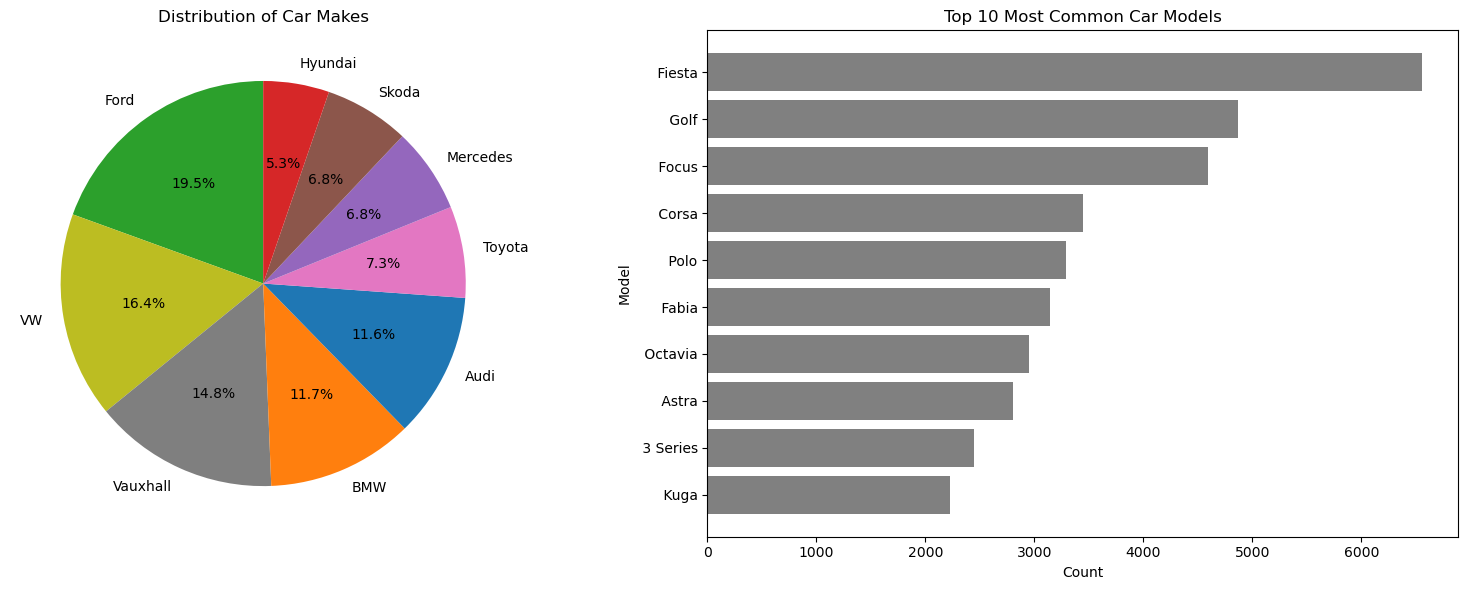

In [557]:
# 3. Overview of car makes and models

# Create a list of unique car makes
unique_makes = uk_cars_data["Make"].unique()

# Count the occurrences of each make and top 10 models
make_counts = uk_cars_data["Make"].value_counts()
model_counts = uk_cars_data["model"].value_counts()
top_10_models = model_counts.head(10)

# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Plot the pie chart in the first subplot
axes[0].pie(make_counts, labels=make_counts.index, autopct='%1.1f%%', startangle=90, colors=[color_map[make] for make in make_counts.index])
axes[0].set_title("Distribution of Car Makes")

# Plot the horizontal bar chart in the second subplot
axes[1].barh(top_10_models.index, top_10_models.values, color=[color_map.get(make, "gray") for make in top_10_models.index])
axes[1].set_xlabel("Count")
axes[1].set_ylabel("Model")
axes[1].set_title("Top 10 Most Common Car Models")
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()


As shown in the pie plot and the bar plot, the most sold used car make is Ford followed by Volkswagen and Vauxhall. For the models, we can observe that the Ford Fiesta is the most sold used car followed by the VW Golf and the Ford Focus. This states that our friend indeed has a car to sell which is quite sought after and/or occurent in the market.

### III. c) GOLF: Environmental Factors of VW Golf CO2 Emissions

Finally, in order to explore the effects of emission performance in concert with economic indicators and car specification on used-car prices, we take Volkswagen's most common car in this dataset, the Golf, and gather the CO2 emissions data from Volkswagen catalogues on their Golf lines of cars from 2015-2020. This is done by gathering the PDFs published by Volkswagen themselves and manually retrieving the emissions levels for each kind, or setup, of car in the data set. These emissions levels are measured in grams per kilometer of carbon dioxide. This 'setup' is determined by four categorical variables: year of make, fuel type, transmission, and engine size. Due to limitations in the catalogues themselves, criteria such as fuel type are restricted to just 'Petrol' and 'Diesel', engine size to 1.0, 1.4, 1.5, 1.6, and 2.0 litres, and transmission to 'Manual' and 'Automatic'. 

In [561]:
vw = pd.read_csv("vw.csv")
vw['model'] = vw['model'].str.strip()
vw['fuelType'] = vw['fuelType'].str.strip()
vw['transmission'] = vw['transmission'].str.strip()
golf = vw[vw['model'] == 'Golf']

display(golf)

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
733,Golf,2019,17000,Manual,8000,Diesel,145,57.7,1.6
734,Golf,2019,36000,Automatic,4000,Petrol,145,32.8,2.0
735,Golf,2015,19390,Automatic,20031,Petrol,200,40.4,2.0
736,Golf,2019,16290,Automatic,14821,Petrol,145,44.8,1.0
737,Golf,2017,16491,Automatic,20693,Petrol,20,60.1,1.4
...,...,...,...,...,...,...,...,...,...
5591,Golf,2015,11750,Manual,79000,Diesel,20,67.3,2.0
5592,Golf,2016,11950,Automatic,41725,Petrol,30,53.3,1.4
5593,Golf,2017,12950,Automatic,44837,Diesel,20,67.3,2.0
5594,Golf,2014,11299,Manual,25495,Petrol,30,53.3,1.4


In [562]:
warnings.filterwarnings("ignore")
def make_setup(row):
    return str(row['year']) + " " + row['transmission'] + " " + row['fuelType'] + " " + str(row['engineSize'])
#golf['setup'] = str(golf['year']) + row['fuelType'].str.strip() + str(row['engineSize'].str.strip())

# Apply the custom function row-wise to concatenate
golf['setup'] = golf.apply(make_setup, axis=1)


In [563]:
# sort df by year
golf = golf.sort_values(by='year')

# just want 2015-2020
golf = golf[golf['year'] > 2014]

# dropping 'Other' and 'Hybrid' fuel types
golf['fuelType'] = golf['fuelType'].str.strip()
golf = golf[golf['fuelType'] != 'Other']
golf = golf[golf['fuelType'] != 'Hybrid']


In [564]:
golf = golf[golf['engineSize'] != 0.0]

# dropping semi-auto transmission
golf = golf[golf['transmission'] != 'Semi-Auto']

In [565]:
vw = pd.read_csv("vw.csv")
vw['model'] = vw['model'].str.strip()
vw['fuelType'] = vw['fuelType'].str.strip()
vw['transmission'] = vw['transmission'].str.strip()
golf = vw[vw['model'] == 'Golf']
display(golf)

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
733,Golf,2019,17000,Manual,8000,Diesel,145,57.7,1.6
734,Golf,2019,36000,Automatic,4000,Petrol,145,32.8,2.0
735,Golf,2015,19390,Automatic,20031,Petrol,200,40.4,2.0
736,Golf,2019,16290,Automatic,14821,Petrol,145,44.8,1.0
737,Golf,2017,16491,Automatic,20693,Petrol,20,60.1,1.4
...,...,...,...,...,...,...,...,...,...
5591,Golf,2015,11750,Manual,79000,Diesel,20,67.3,2.0
5592,Golf,2016,11950,Automatic,41725,Petrol,30,53.3,1.4
5593,Golf,2017,12950,Automatic,44837,Diesel,20,67.3,2.0
5594,Golf,2014,11299,Manual,25495,Petrol,30,53.3,1.4


In [566]:
def make_setup(row):
    return str(row['year']) + " " + row['transmission'] + " " + row['fuelType'] + " " + str(row['engineSize'])

# apply above function
golf['setup'] = golf.apply(make_setup, axis=1)


In [567]:
# sort df by year
golf = golf.sort_values(by='year')

# just want 2015-2020
golf = golf[golf['year'] > 2014]

# dropping 'Other' and 'Hybrid' fuel types
golf['fuelType'] = golf['fuelType'].str.strip()
golf = golf[golf['fuelType'] != 'Other']
golf = golf[golf['fuelType'] != 'Hybrid']

# dropping 0L engines; not found in catalogues
golf = golf[golf['engineSize'] != 0.0]

# dropping semi-auto transmission
golf = golf[golf['transmission'] != 'Semi-Auto']

In [568]:
emissions_dict = {
    '2015 Manual Petrol 2.0' : 139,
    '2015 Manual Diesel 2.0' : 106,
    '2015 Manual Petrol 1.4' : 120,
    '2015 Manual Diesel 1.6' : 99,
    '2015 Automatic Diesel 1.6' : 102,
    '2015 Automatic Diesel 2.0' : 117,
    '2015 Automatic Petrol 2.0' : 145,
    '2015 Automatic Petrol 1.4' : 116,
    '2015 Manual Petrol 1.2' : 113, 
    '2016 Automatic Diesel 1.6' : 102,
    '2016 Manual Petrol 1.4' : 120, 
    '2016 Manual Diesel 2.0' : 109,
    '2016 Manual Diesel 1.6' : 103,
    '2016 Automatic Petrol 2.0' : 145,
    '2016 Manual Petrol 2.0' : 148,
    '2016 Automatic Diesel 2.0' : 117,
    '2016 Automatic Petrol 1.4' : 120,
    '2016 Manual Petrol 1.0' : 105,
    '2016 Automatic Petrol 1.0' : 103, 
    '2016 Manual Petrol 1.2' : 113,
    '2017 Manual Petrol 1.0' : 105,
    '2017 Manual Diesel 1.6' : 105,
    '2017 Manual Petrol 1.4' : 120, 
    '2017 Manual Petrol 2.0' : 162, 
    '2017 Automatic Petrol 1.4' : 116,
    '2017 Manual Diesel 2.0' : 114, 
    '2017 Automatic Diesel 2.0' : 127,
    '2017 Manual Petrol 1.2' : 113, 
    '2017 Automatic Petrol 2.0' : 160,
    '2017 Automatic Diesel 1.6' : 104,
    '2017 Automatic Petrol 1.0' : 103, 
    '2017 Automatic Diesel 1.4' : 102,
    '2018 Manual Petrol 1.4' : 120,
    '2018 Manual Petrol 2.0' : 148, 
    '2018 Automatic Petrol 2.0' : 148,
    '2018 Manual Petrol 1.0' : 108, 
    '2018 Manual Diesel 1.6' : 106,
    '2018 Manual Diesel 2.0' : 109, 
    '2018 Automatic Petrol 1.4' : 119,
    '2018 Manual Petrol 1.5' : 110, 
    '2018 Automatic Diesel 2.0' : 114,
    '2018 Automatic Petrol 1.5' : 110, 
    '2018 Automatic Diesel 1.6' : 102,
    '2018 Automatic Petrol 1.0' : 108, 
    '2019 Manual Diesel 1.6' : 109,
    '2019 Manual Petrol 1.5' : 130, 
    '2019 Automatic Petrol 1.5' : 130,
    '2019 Manual Petrol 1.0' : 109,
    '2019 Automatic Diesel 2.0' : 116,
    '2019 Manual Diesel 2.0' : 115,
    '2019 Automatic Diesel 1.6' : 104,
    '2019 Automatic Petrol 1.0' : 110, 
    '2020 Manual Diesel 1.6' : 134,
    '2020 Automatic Petrol 1.5' : 145, 
    '2020 Manual Petrol 1.5' : 135,
    '2020 Automatic Diesel 2.0' : 142, 
    '2020 Manual Diesel 2.0' : 137, 
    '2020 Manual Petrol 1.0' : 115
    }

golf['CO2 Emissions'] = golf['setup'].map(emissions_dict).astype("float64")

In [569]:
golf = golf.dropna()


## IV. Data Visualization

### IV. a) ALL: UK Used Cars & Economic Influence

Text(0.5, 1.0, 'ONS economic data matrix')

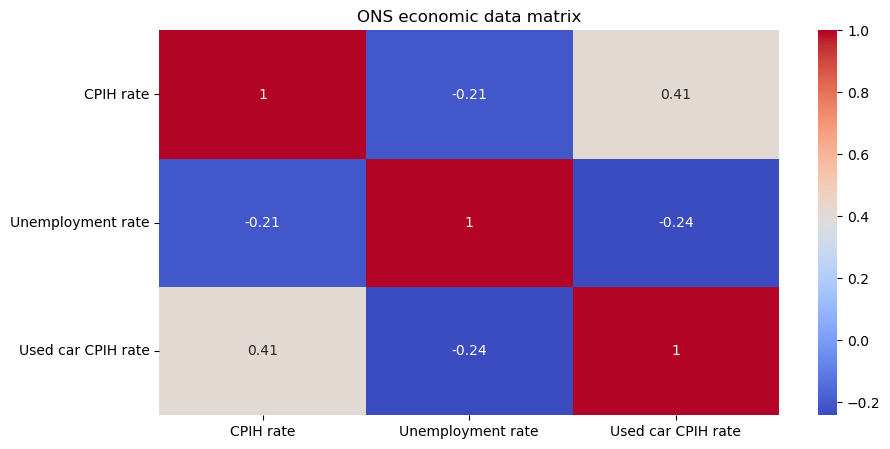

In [572]:
# Plot the correlations between the economic factors
# Select the non-year columns (i.e., the fields with economic data)
ons_merged_data_no_year = ons_merged_data.drop(columns = ["Period"])

# Create a matrix to store the correlations
ons_corr = ons_merged_data_no_year.corr()

# Plot the correlation matrix as a heatmap
sns.heatmap(ons_corr, annot = True, cmap = "coolwarm")
plt.title("ONS economic data matrix")


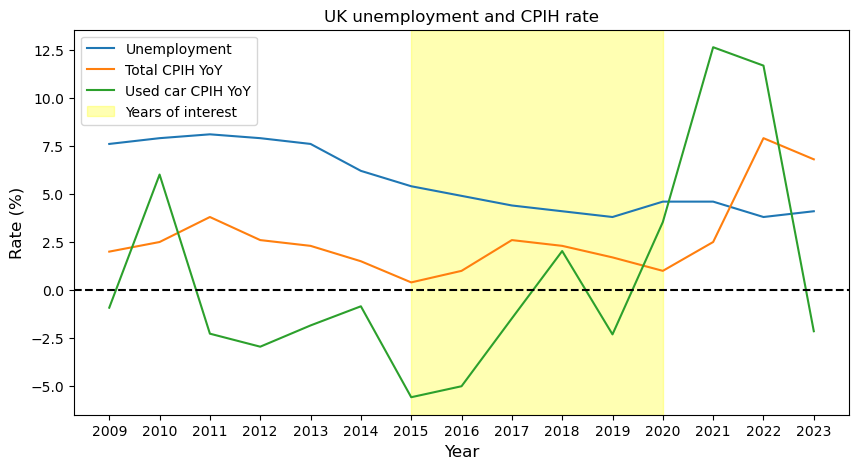

In [573]:
# Graphing the combined ONS economic factors data
fig, ax = plt.subplots()

# Lineplots for UK unemployment rate, overall CPIH year-over-year (YoY) rate, and used car CPIH YoY rate from 2009-2023
ax.plot(ons_merged_data["Period"], ons_merged_data["Unemployment rate"], label = "Unemployment")
ax.plot(ons_merged_data["Period"], ons_merged_data["CPIH rate"], label = "Total CPIH YoY")
ax.plot(ons_merged_data["Period"], ons_merged_data["Used car CPIH rate"], label = "Used car CPIH YoY")

ax.axhline(0, linestyle = "--", color = "black") # Include line x = 0, to provide additional clarity for when rate becomes negative
plt.xticks(range(2009, 2024)) # Ensure there is an x-axis "tick" mark for every year
ax.axvspan(xmin = 2015, xmax = 2020, color = "yellow", alpha = 0.3, label= "Years of interest") # Specify the years of interest that we will examine in the future for the Volkswagen Golf prices

plt.title("UK unemployment and CPIH rate")
ax.set_xlabel("Year", fontsize = 12)
ax.set_ylabel("Rate (%)", fontsize = 12)

ax.legend()
plt.show()

### IV. b) SAMPLE: UK Used Cars

#### IV. b) (i) Clustering into lower, mid, higher segment using price

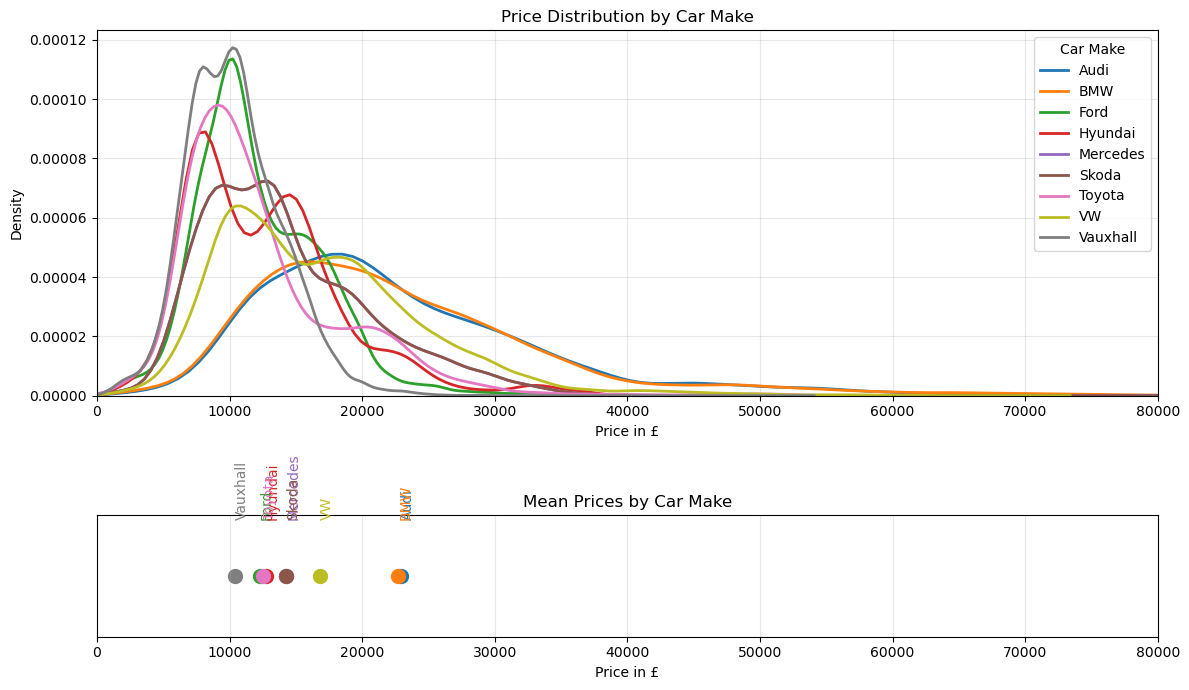

In [645]:
# Calculate mean prices for each make
make_means = uk_cars_data.groupby("Make")["price"].mean()

# Filter data for the makes in make_means
filtered_data = uk_cars_data[uk_cars_data["Make"].isin(make_means.index)]

# Set up the figure and axes
fig, axes = plt.subplots(2, 1, figsize=(12, 7), gridspec_kw={'height_ratios': [3, 1]})

# First plot: KDE curves
for make in make_means.index:
    sns.kdeplot(data=filtered_data[filtered_data["Make"] == make], x="price", label=make, ax=axes[0], linewidth=2, color=color_map[make])
axes[0].set_title("Price Distribution by Car Make")
axes[0].set_xlabel("Price in £")
axes[0].set_ylabel("Density")
axes[0].legend(title="Car Make")
axes[0].grid(alpha=0.3)
axes[0].set_xlim((0, 80000))  # Set x-axis range for KDE plot

# Second plot: Mean prices on a single-dimensional line
for make in make_means.index:
    axes[1].scatter(make_means[make], 0, color=color_map[make], s=100, label=make)
axes[1].set_yticks([])  # Remove y-axis ticks for clarity
axes[1].set_xlim((0, 80000))  # Match x-axis range for the mean plot
axes[1].set_title("Mean Prices by Car Make")
axes[1].set_xlabel("Price in £")
axes[1].grid(alpha=0.3)

# Annotate means with car make labels
for make, mean in make_means.items():
    axes[1].text(mean, 0.05, make, rotation=90, va='bottom', fontsize=10, color=color_map[make])

plt.tight_layout()
plt.show()

In this chart we are able to observe the distribution of car prices per car make. Additionally, by plotting the individual car price means per car make onto a one-dimensional line we can form car price clusters. This process helps us to advise our friend which car makes are his immediate competition when selling the VW Golf.

#### IV. b) (ii) Define the segments and their corresponding makes

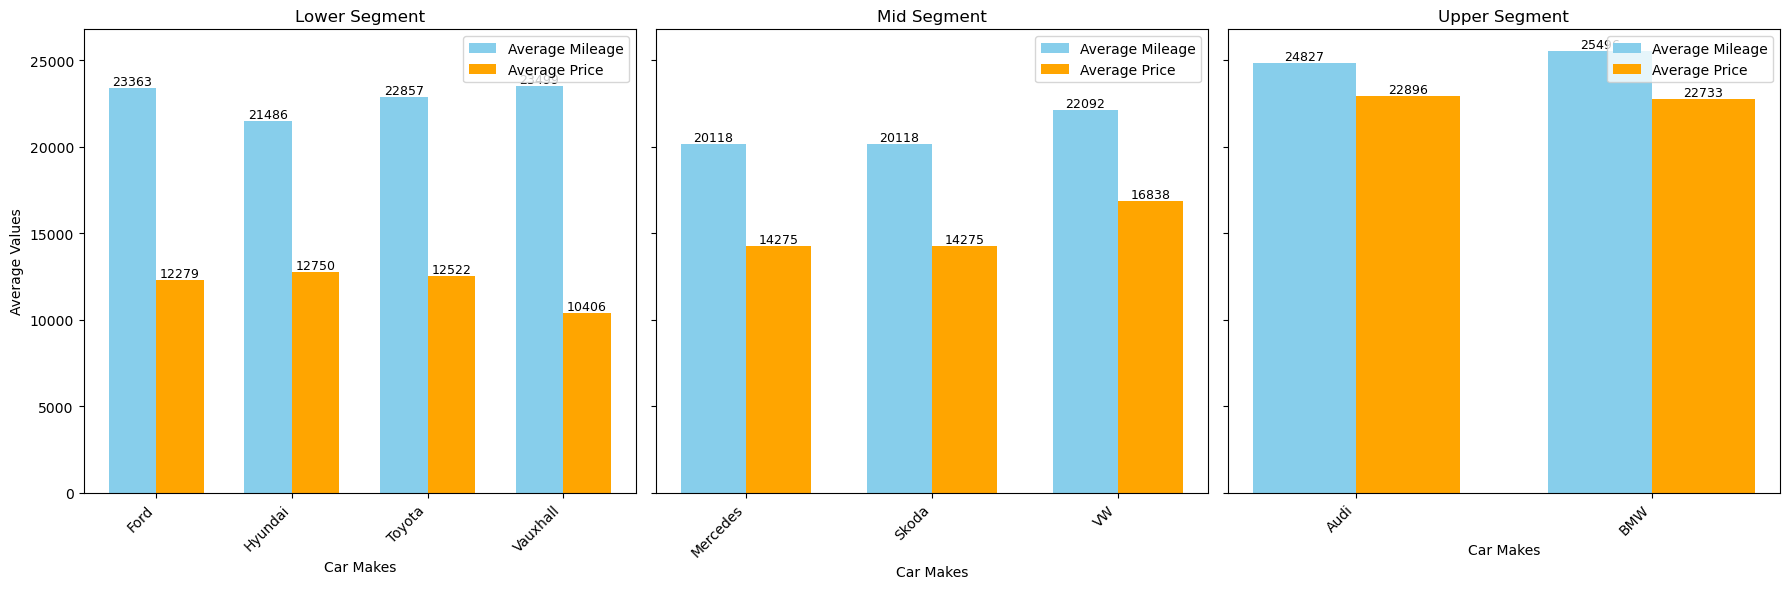

In [579]:
# Define the segments and their corresponding makes
segments = {
    "Lower Segment": ["Vauxhall", "Ford", "Toyota", "Hyundai"],
    "Mid Segment": ["Skoda", "Mercedes", "VW"],
    "Upper Segment": ["Audi", "BMW"]
}

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Group data by 'Make' and calculate average mileage and price
make_stats = uk_cars_data.groupby('Make')[['mileage', 'price']].mean().reset_index()

# Plot for each segment
for idx, (segment_name, makes) in enumerate(segments.items()):
    segment_stats = make_stats[make_stats['Make'].isin(makes)]
    x = np.arange(len(segment_stats['Make']))
    width = 0.35
    average_mileage = segment_stats['mileage']
    average_price = segment_stats['price']
    
    # Plot bars for mileage and price
    bars1 = axes[idx].bar(x - width/2, average_mileage, width, label='Average Mileage', color='skyblue', capsize=5)
    bars2 = axes[idx].bar(x + width/2, average_price, width, label='Average Price', color='orange', capsize=5)

    # Customize the subplot
    for bar in bars1:
        axes[idx].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{int(bar.get_height())}', ha='center', va='bottom', fontsize=9)
    for bar in bars2:
        axes[idx].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{int(bar.get_height())}', ha='center', va='bottom', fontsize=9)
    axes[idx].set_title(segment_name)
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels(segment_stats['Make'], rotation=45, ha='right')
    axes[idx].set_xlabel('Car Makes')
    axes[idx].set_ylabel('Average Values' if idx == 0 else "")
    axes[idx].legend(loc='upper right')

plt.tight_layout()
plt.show()

By plotting the price clusters of the lower, mid, and upper segment we can compare the immediate competition when selling the VW Golf. Additionally, adding the mean mileage per car make helps to see how much the average car is used before selling it on the used car market. So comparing the average price and mileage per car make gives an indication of when it is best to sell a car according to the average car price and average car mileage given the car make.

#### IV. b) (iii) Distribution of Price/Mileage

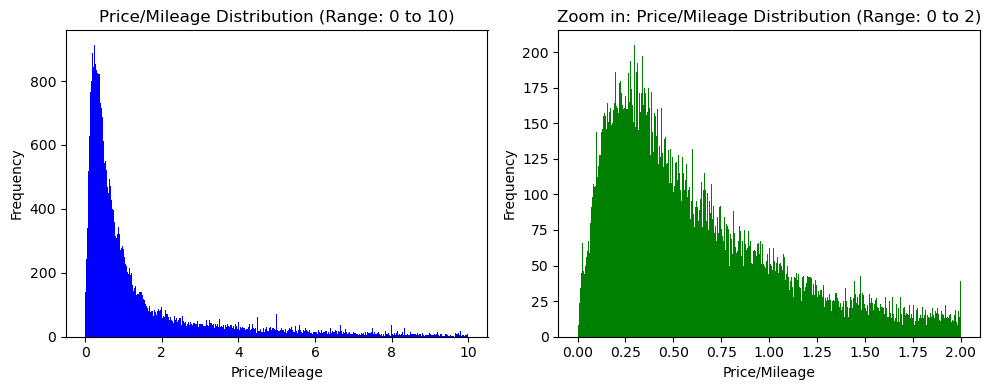

In [582]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# General histogram
axes[0].hist(uk_cars_data["price/mileage"], bins=1000, range=(0, 10), color='blue')
axes[0].set_title("Price/Mileage Distribution (Range: 0 to 10)")
axes[0].set_xlabel("Price/Mileage")
axes[0].set_ylabel("Frequency")

# Zoomed-in histogram
axes[1].hist(uk_cars_data["price/mileage"], bins=1000, range=(0, 2), color='green')
axes[1].set_title("Zoom in: Price/Mileage Distribution (Range: 0 to 2)")
axes[1].set_xlabel("Price/Mileage")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

When analyzing all used cars in the sample dataset, we observe the price-to-mileage index, which serves as a standardized metric to compare cars regardless of variations in their mileage and price. By examining the graph, we find that the majority of cars have a price-to-mileage index between 0 and 2. This range provides a useful benchmark for estimating a reasonable price interval for our friend’s car, based on the general trends observed in the sample of all used cars.

### IV. c) GOLF: UK Used Cars & Environmental Factors

#### IV. c) (i) Golf vs Other VW Models

In [586]:
# setting new column to classify entries as 'Golf' or 'Other' 
vw['golf_vs_other'] = vw['model'].str.strip().apply(lambda i: 'Other' if i != 'Golf' else i)

golf_vs_other
Other    10294
Golf      4863
Name: count, dtype: int64

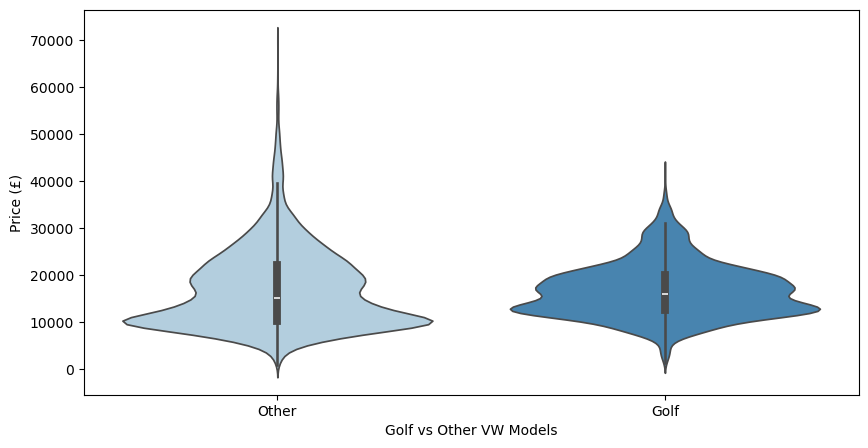

In [587]:
sns.violinplot(x='golf_vs_other', y='price', hue='golf_vs_other', data=vw, palette="Blues", legend=False)
plt.xlabel("Golf vs Other VW Models")
plt.ylabel("Price (£)")

vw['golf_vs_other'].value_counts()

The code and plot above show a couple important takeaways: (1) that Golfs take up a meaningful proportion of all VWs sold, about 32%, and (2) that the distribution of used Golf's selling price is relatively representative of the broader market. This affirms the use the key covariates in used car sales to inform the instance of putting a VW Golf to market. 


#### IV. c) (ii) Correlation Across Covariates  

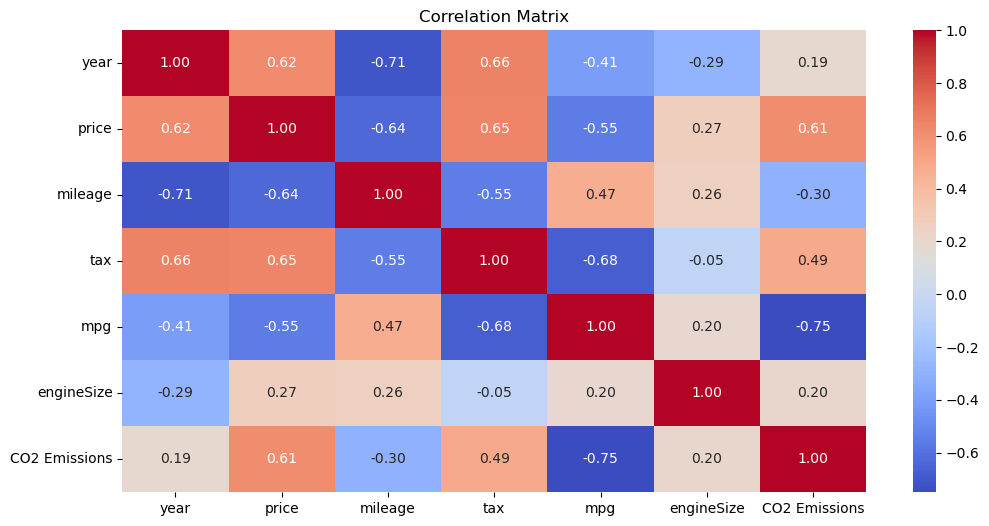

In [590]:
# Select only numeric columns
golf_numr = golf.select_dtypes(include=['float64', 'int64']).copy()

# Create a matrix to store the correlations
golf_corr = pd.DataFrame(index=golf_numr.columns, columns=golf_numr.columns)

# Calculate the correlations
for i in range(len(golf_numr.columns)):
    for j in range(len(golf_numr.columns)):
        golf_corr.iloc[i, j] = golf_numr.iloc[:, i].corr(golf_numr.iloc[:, j])

# Convert to numeric
golf_corr = golf_corr.apply(pd.to_numeric, errors='coerce')

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(golf_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

#### IV. c) (iii) Incorporating Emissions Data

In [592]:
golf['bucket'] = pd.cut(golf['price'], 
                        bins=range(min(golf['price']), max(golf['price']), 1000), 
                        right=False, 
                        labels=[i/1000 for i in range(min(golf['price']), max(golf['price']) - 1000, 1000)])
golf = golf.dropna()

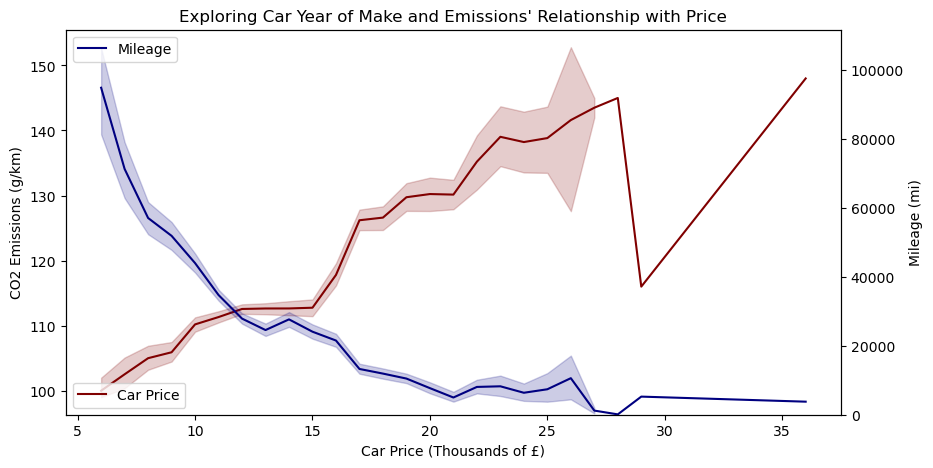

In [593]:
fig, ax1 = plt.subplots()

sns.lineplot(x='bucket', y='CO2 Emissions', data=golf, label='Car Price', color='maroon')
ax1.set_xlabel('Car Price (Thousands of £)')
ax1.set_ylabel('CO2 Emissions (g/km)')
ax1.tick_params(axis='y')
ax1.legend(loc = 'lower left')

ax2 = ax1.twinx()

sns.lineplot(x='bucket', y='mileage', data=golf, label='Mileage', color="navy")
ax2.set_ylabel('Mileage (mi)')
ax2.tick_params(axis='y')
ax2.legend(loc = 'upper left')
ax2.hist(golf['bucket'], alpha=.5, density=True)


plt.title("Exploring Car Year of Make and Emissions' Relationship with Price")
plt.show()


The above plot shows both CO2 emissions levels and odometer mileage against sale price the VW Golf dataset. The key takeaways are that mileage exhibits a strong negative and weakly exponential relationship with car price, and that CO2 emissions exhibits a strong positive relationship against price, with outlier behavior having strong influence at the higher end of the price scale, starting at around £25,000. This allows for someone selling their Golf to see what most Golf's in the same situation may be selling for, or at the very least being listed for. 


## V. Data Modeling

#### V. a) Model Linear Regression on Golf Car Data Variables

In [597]:
import statsmodels.api as sm

# Define the predictor variable (price) and independent variables (others)
X = golf_numr.drop(columns=['price'])
y = golf_numr['price']

# Add a constant term to the independent variables (for the intercept)
X = sm.add_constant(X)

# Fit the linear regression model using statsmodels
model = sm.OLS(y, X).fit()

# Generate the summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     2104.
Date:                Wed, 22 Jan 2025   Prob (F-statistic):               0.00
Time:                        23:08:48   Log-Likelihood:                -26089.
No. Observations:                2944   AIC:                         5.219e+04
Df Residuals:                    2937   BIC:                         5.223e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -2.12e+06   7.14e+04    -29.690

The results of our linear regression provide a reasonably robust model to estimate the price of our friend's VW Golf. The R-squared value indicates that 81.1% of the total variation in car price can be explained by the features included in the model, while the remaining variation is captured in the residual errors. All the regressors, except for the "tax" variable, are statistically significant and should be included in the model. The "tax" variable, however, does not have sufficient statistical evidence to reject the null hypothesis that its coefficient is equal to zero and should therefore be excluded from the model.

In [675]:
# Drop the "tax" variable from the independent variables
X = golf_numr.drop(columns=['price', 'tax'])

# Add a constant term to the independent variables (for the intercept)
X = sm.add_constant(X)

# Fit the linear regression model again without the "tax" variable
model2 = sm.OLS(y, X).fit()

# Generate the summary
print(model2.summary())


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     2523.
Date:                Wed, 22 Jan 2025   Prob (F-statistic):               0.00
Time:                        23:44:47   Log-Likelihood:                -26090.
No. Observations:                2944   AIC:                         5.219e+04
Df Residuals:                    2938   BIC:                         5.223e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -2.179e+06   6.16e+04    -35.376

Since the R-squared value stayed at 81.1% we see that removing the "tax" regressor did not increase the residual sum of squares, thus reinforcing the fact that "tax" should be removed from the model.

### V. b) Predicted price for our friend's VW Golf

In [679]:
# predict a sales price for our friend

X_friend = pd.DataFrame({
    'const': [1],
    'year': [2018],
    'mileage': [60000],
    'mpg': [40.4],
    'engineSize': [2.0],
    'emissions': [148]
})

sales_price = model2.predict(X_friend)
print(f"The estimated sales price for our friend's VW Golf is £{sales_price[0]:.2f}")

The estimated sales price for our friend's VW Golf is £19077.11


## VI. Conclusion

In this exploration of the UK used-car market, we aimed to provide actionable insights for anyone interested in understanding how economic and environmental factors interact with the market, as well as specfically helping our friend to sell his car. 

**1. ALL: UK Used Cars & Economic Influence** <br>
Beginning with high-level data, we examined economic indicators such as unemployment rates and the Consumer Prices Index including Housing (CPIH) in relation to car sales volumes, specifically analyzing the periods around 2015 and 2020. Our analysis revealed a negative correlation between unemployment rates and the used car CPIH, while the general CPIH positively correlates with the used car CPIH, highlighting the interplay between economic conditions and market behavior.

**2. SAMPLE: UK Used Cars** <br>
We further segmented the UK used-car market into three price clusters—lower, mid, and upper segments. Notably, the Volkswagen Golf, a mid-segment car, emerged as a key focus of our research. In addition to that we can see the average prices of other car makes and their average mileages which enables our friend to see where his VW Golf is located within the market. By analyzing price-to-mileage ratios across all cars, we observed that most vehicles have a price/mileage index between 0 and 2, offering a benchmark for evaluating a fair market price. 

**3. GOLF: Environmental Factors of VW Golf CO2 Emissions** <br>
Diving deeper to the specific case of our friend's VW Golf, we identified key factors influencing car prices: CO2 emissions, annual tax, and the car’s manufacturing year were positively correlated with price, whereas mileage had a significant negative impact. This shows that our friend should be mostly concerned about the mentioned features as they are the most crucial when it comes to a selling price. Synthesizing insights from both high-level economic data and granular vehicle-specific data, we provided a tailored tipps and facts to keep in mind for our friend selling his Volkswagen Golf. Based on the car’s attributes and our regression analysis (based on , we estimate its market value to be approximately £19,077. 

**4. Limitations and Improvements** <br>
Looking ahead, future analyses could be enriched by incorporating more comprehensive emissions data beyond CO2, and including location and time-of-sale variables in used-car market data. These additions would provide deeper context and allow for even more robust predictive modeling. By combining multiple data sources and employing statistical and machine learning techniques, we have not only offered a potential sales price but also demonstrated how data-driven insights can empower sellers to make informed decisions in the used-car market.